# Mult-VAE

- [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/pdf/1802.05814.pdf)
- [참고](https://jrzaurin.github.io/infinitoml/2020/05/15/mult-vae.html)

# CVAE

- [Collaborative Variational Autoencoder for Recommender Systems
](http://cseweb.ucsd.edu/classes/fa17/cse291-b/reading/p305-li.pdf)

# RecVAE
- [RecVAE: a New Variational Autoencoder for Top-N Recommendations with Implicit Feedback](https://arxiv.org/pdf/1912.11160.pdf)

## Experiment

- sampling vs training all
- multinomial vs logistic

In [1]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple, List

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [2]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '100k':
        file = get_file('ml-100k.zip', 'http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        file_name = 'ml-100k/*'
    elif data_size == '1m':
        file = get_file('ml-1m.zip', 'http://files.grouplens.org/datasets/movielens/ml-1m.zip')
        file_name = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        file = get_file('ml-10m.zip', 'http://files.grouplens.org/datasets/movielens/ml-10m.zip')
        file_name = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        file = get_file('ml-20m.zip', 'http://files.grouplens.org/datasets/movielens/ml-20m.zip')
        file_name = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        file = get_file('ml-25m.zip', 'http://files.grouplens.org/datasets/movielens/ml-25m.zip')
        file_name = 'ml-25m/ratings.csv'
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(file_name, engine = 'python')
    else:
        ratings = pd.read_csv(file_name, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [3]:
ratings = load_data('1m')
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1. Data Preprocessing

In [4]:
def preprocessing(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    df = df[df.rating >= threshold]
    positive = df.groupby('userId')['movieId'].nunique()
    positive = positive.index[positive >= 5]
    df = df[df.userId.isin(positive)]
    return df.reset_index(drop = True)

In [5]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}
n_user = idx_user_map.shape[0]
print(f'# of user = {n_user}')

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}
n_item = idx_item_map.shape[0]
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [6]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [7]:
ratings = preprocessing(ratings)
ratings = Id2idx(ratings)

print(ratings.shape)
ratings.head(5)

(575272, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,3,4,978300275
2,0,4,5,978824291
3,0,6,5,978302039
4,0,7,5,978300719


In [8]:
def split_data(df: pd.DataFrame) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.userId.unique(), test_size = 0.2, random_state = 7777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, random_state = 7777)

    train, valid, test = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def fold_in(df: pd.DataFrame) -> pd.DataFrame:
    query, answer = train_test_split(df, test_size = 0.2, stratify = df.userId, random_state = 7777)
    query, answer = map(lambda df: df.sort_values(['userId', 'timestamp']), (query, answer))
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

def mutate_data(df: pd.DataFrame) -> pd.DataFrame: # list aggregation
    return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)

In [46]:
def train_generator(df: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4,
                    corruption = 0.5,
                    sampling = True,
                    NS = 5) -> Tuple[np.array, np.array]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    if sampling:
        while True:
            batch_Id = np.random.choice(Ids, size = batch_size)
            batch = np.zeros(shape = (batch_size, n_col))
            
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                batch[i, pos] = rating[idx]

            yield batch, batch
    else:
        while True:
            np.random.shuffle(Ids)
        
            for batch_step in range(n_batch):
                lower = batch_step * batch_size
                upper = lower + batch_size
                
                batch_Id = Ids[lower: upper]
                batch = np.zeros(shape = (batch_Id.size, n_col))
                for i, idx in enumerate(batch_Id):
                    pos = np.array(profile[idx])

                    # neg_n = len(pos) * NS
                    # neg = np.random.choice(np.delete(np.arange(n_col), pos), neg_n)
                    
                    # p = np.random.uniform(0, 1, size = pos.shape)
                    # cor = pos[p < corruption]

                    batch[i, pos] = rating[idx]
                    # batch[i, neg] = np.finfo(float).eps
                    # batch[i, cor] = 0
                
                yield batch, batch

In [47]:
def valid_generator(df: pd.DataFrame,
                    n_item: int,
                    batch_size: int,
                    implicit = True,
                    threshold = 4) -> Tuple[np.array, np.array]:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                pos = np.array(profile[idx])
                batch[i, pos] = rating[idx]
            yield batch, batch

In [48]:
def masked_mae(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = tf.cast(tf.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ae = K.abs(mask_true * (y_true - y_pred))
    return K.sum(masked_ae, axis = -1) / K.sum(mask_true, axis = -1)

def rmse(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    se = K.square(mask_true * (y_true - y_pred))
    return K.sqrt(K.mean(masked_se, axis = -1))

def masked_rmse(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_se = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_se, axis = -1) / K.sum(mask_true, axis = -1)
    return K.sqrt(masked_mse)

def cross_entropy(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    ce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
    return -K.sum(ce, axis = -1)

def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    ce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
    masked_ce = mask_true * ce
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

def masked_log_loss(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    loss = y_true * K.log(y_pred)
    masked_loss = mask_true * loss
    return -K.sum(masked_loss, axis = -1) / K.sum(mask_true, axis = -1)

def log_loss(y_true: np.array, y_pred: np.array) -> tf.Tensor:
    return -K.sum(y_true * K.log(y_pred), axis = -1)

In [49]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(shape = (batch, dim))

In [50]:
def VAE(n_user: int,
        n_item: int,
        latent_dim = 200,
        activation = 'tanh',
        optimizer = 'adam',
        dropout_rate = 0.5,
        kernel_initializer = None,
        kernel_regularizer = None,
        likelihood = 'logistic',
        beta = 1) -> Callable:

    if not kernel_initializer:
        kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    if not kernel_regularizer:
        kernel_regularizer = l2(0.001)

    if likelihood == 'multinomial':
        loss = log_loss
        last_activation = 'softmax'
    elif likelihood == 'logistic':
        loss = cross_entropy
        last_activation = 'sigmoid'
    elif likelihood == 'gaussian':
        loss = rmse
        last_activation = 'sigmoid'
    
    inputs = x = Input(shape = (n_item, ), name = 'input')
    x = Dropout(dropout_rate)(x)
    z_mean = Dense(latent_dim, 
                   activation = activation, 
                   kernel_initializer = kernel_initializer,
                   kernel_regularizer = kernel_regularizer, 
                   name = 'mean')(x)
    z_log_var = Dense(latent_dim, 
                      activation = activation, 
                      kernel_initializer = kernel_initializer,
                      kernel_regularizer = kernel_regularizer,
                      name = 'log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    outputs = Dense(n_item, 
                    activation = last_activation,
                    kernel_initializer = kernel_initializer,
                    name = 'output')(z)

    model = Model(inputs = inputs, outputs = outputs, name = 'VAE')
    
    lh_loss = loss(inputs, outputs)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis = -1)
    vae_loss = K.mean(lh_loss + beta * kl_loss)

    model.add_loss(vae_loss)
    model.compile(optimizer = optimizer, metrics = masked_mae)
    return model

In [51]:
def test_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   implicit = True,
                   threshold = 4,
                   top_N = 20) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']
    rating = df['rating'] if not implicit else df['rating'].apply(lambda x: [1 if r >= threshold else 0 for r in x])

    res = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = rating[idx]

        y_pred = model.predict(y_true, verbose = 0)
        
        rec = np.argsort(np.where(y_true == 1, -1, y_pred), axis = -1)[:, :-top_N-1:-1]
        res.append(rec)
    return np.concatenate(res)

In [52]:
def show_history(hist, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(hist.history[f'{loss}'])
    ax1.plot(hist.history[f'val_{loss}'])
    ax1.set_title('Loss', fontsize = 20)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss', 'val_loss'], loc = 'upper right')

    ax2.plot(hist.history[f'{metric}'])
    ax2.plot(hist.history[f'val_{metric}'])
    ax2.set_title('Metric', fontsize = 20)
    ax2.set_ylabel('metric')
    ax2.set_xlabel('epoch')
    ax2.legend(['masked_metric', 'val_masked_metric'], loc = 'upper right')
    plt.show()

In [53]:
def ndcg(gt, rec):
    dcg, idcg = 0.0, 0.0
    for i, r in enumerate(rec):
        idcg += 1.0 / np.log(i + 2)
        if r in gt:
            dcg += 1.0 / np.log(i + 2)
    return dcg / idcg

def recall(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(gt)

def precision(gt, rec):
    res = [r for r in rec if r in gt]
    return len(res) / len(rec)

def precision_k(gt, rec, k):
    rec_k = rec[:k+1]
    res = [r for r in rec_k if r in gt]
    return len(res) / k

def AP_k(gt, rec, k = 20):
    res = 0
    for i in range(k):
        if rec[i] in gt:
            res += precision_k(gt, rec, i+1)
    return res / min(k, len(gt))

### 1. Multinomial Likelihood

In [54]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = VAE(n_user, n_item, latent_dim = 200, optimizer = optimizer, likelihood = 'multinomial')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 3706)         0           input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      dropout_3[0][0]                  
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      dropout_3[0][0]                  
________________________________________________________________________________________________

In [55]:
epochs = 200
batch_size = 256

train, valid, test = split_data(ratings)
(valid_q, valid_a), (test_q, test_a) = map(fold_in, (valid, test))
train, valid_q, valid_a, test_q, test_a = map(mutate_data, (train, valid_q, valid_a, test_q, test_a))

train_gen = train_generator(train, n_item, batch_size)
valid_gen = valid_generator(valid_q, n_item, batch_size)

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid_q.index.size // batch_size + 1

In [56]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('VAE.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/200
19/19 [==============================] - 1s 33ms/step - loss: 791.8378 - masked_mae: 0.9996 - val_loss: 593.8510 - val_masked_mae: 0.9993
Epoch 2/200
19/19 [==============================] - 1s 41ms/step - loss: 745.0768 - masked_mae: 0.9991 - val_loss: 579.2166 - val_masked_mae: 0.9992
Epoch 3/200
19/19 [==============================] - 1s 35ms/step - loss: 749.0226 - masked_mae: 0.9990 - val_loss: 566.5759 - val_masked_mae: 0.9989
Epoch 4/200
19/19 [==============================] - 1s 40ms/step - loss: 737.2009 - masked_mae: 0.9987 - val_loss: 557.8273 - val_masked_mae: 0.9988
Epoch 5/200
19/19 [==============================] - 1s 36ms/step - loss: 715.9170 - masked_mae: 0.9985 - val_loss: 551.7698 - val_masked_mae: 0.9986
Epoch 6/200
19/19 [==============================] - 0s 26ms/step - loss: 706.5453 - masked_mae: 0.9984 - val_loss: 546.4013 - val_masked_mae: 0.9985
Epoch 7/200
19/19 [==============================] - 1s 30ms/step - loss: 711.9334 - masked_mae: 0.9

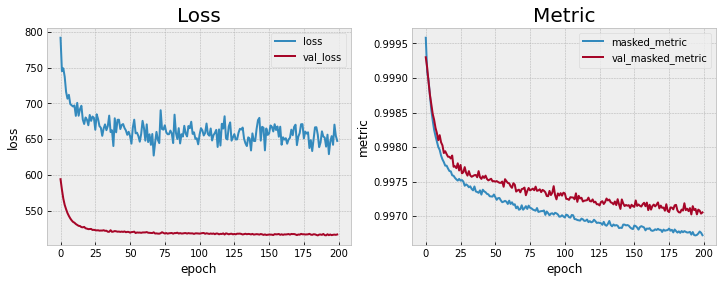

In [57]:
show_history(hist, 'loss', 'masked_mae')

In [58]:
pred = test_predictor(test_q, model, n_item, batch_size)
pred

array([[ 171,   38,  116, ...,    9,  149,   89],
       [1015,  758,  591, ...,   47,  338,  852],
       [  60,   97,  128, ...,  891,  267,  317],
       ...,
       [  51,   23, 2438, ..., 1001,  136,  213],
       [ 127,  199,  104, ...,   48,  217,  434],
       [ 669,   44,   48, ...,  714,  210,  132]])

In [59]:
def evaluator(true: pd.DataFrame, pred):
    m_ndcg = 0
    m_recall = 0
    m_precision = 0
    map_k = 0
    for i in range(len(pred)):
        rec = pred[i]
        gt = true.at[i, 'movieId']
        m_ndcg += ndcg(gt, rec)
        m_recall += recall(gt, rec)
        m_precision += precision(gt, rec)
        map_k += AP_k(gt, rec)
    m_ndcg /= len(pred)
    m_recall /= len(pred)
    m_precision /= len(pred)
    map_k /= len(pred)
    return m_ndcg, m_recall, m_precision, map_k

In [60]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.17752 
Recall: 0.19425 
Precision: 0.15629 
MAP: 0.11711


In [38]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.16871 
Recall: 0.18995 
Precision: 0.15265 
MAP: 0.10620


### 2. Logistic

In [61]:
optimizer = Adam(learning_rate = 0.001, decay = 1e-5)
model = VAE(n_user, n_item, latent_dim = 200, optimizer = optimizer, likelihood = 'logistic')
model.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3706)]       0                                            
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 3706)         0           input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 200)          741400      dropout_4[0][0]                  
__________________________________________________________________________________________________
log_var (Dense)                 (None, 200)          741400      dropout_4[0][0]                  
________________________________________________________________________________________________

In [62]:
epochs = 200
batch_size = 256

train, valid, test = split_data(ratings)
(valid_q, valid_a), (test_q, test_a) = map(fold_in, (valid, test))
train, valid_q, valid_a, test_q, test_a = map(mutate_data, (train, valid_q, valid_a, test_q, test_a))

train_gen = train_generator(train, n_item, batch_size)
valid_gen = valid_generator(valid_q, n_item, batch_size)

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid_q.index.size // batch_size + 1

In [63]:
%%time
early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
model_checkpoint = ModelCheckpoint('VAE.h5', monitor = 'val_loss', mode = 'min', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/200
19/19 [==============================] - 1s 30ms/step - loss: 2026.4200 - masked_mae: 0.6105 - val_loss: 1029.1700 - val_masked_mae: 0.7595
Epoch 2/200
19/19 [==============================] - 1s 41ms/step - loss: 739.5969 - masked_mae: 0.8231 - val_loss: 560.0703 - val_masked_mae: 0.8232
Epoch 3/200
19/19 [==============================] - 1s 36ms/step - loss: 565.4443 - masked_mae: 0.8408 - val_loss: 500.7229 - val_masked_mae: 0.8311
Epoch 4/200
19/19 [==============================] - 1s 41ms/step - loss: 541.9841 - masked_mae: 0.8453 - val_loss: 480.8725 - val_masked_mae: 0.8343
Epoch 5/200
19/19 [==============================] - 1s 27ms/step - loss: 524.8501 - masked_mae: 0.8484 - val_loss: 465.1806 - val_masked_mae: 0.8333
Epoch 6/200
19/19 [==============================] - 0s 26ms/step - loss: 510.2445 - masked_mae: 0.8480 - val_loss: 455.9314 - val_masked_mae: 0.8427
Epoch 7/200
19/19 [==============================] - 0s 26ms/step - loss: 495.6709 - masked_mae: 0

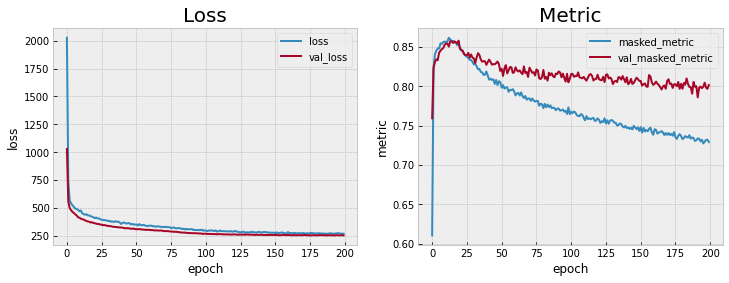

In [64]:
show_history(hist, 'loss', 'masked_mae')

In [65]:
pred = test_predictor(test_q, model, n_item, batch_size)
pred

array([[  27,   44,   92, ...,  726,  128,  911],
       [  22,   60,  528, ...,  521,  193,  738],
       [ 128,  167,  317, ...,  189,  669,  501],
       ...,
       [ 860, 1935,  872, ...,  557,   38, 1491],
       [ 127,  726, 1253, ...,  105, 1195,   40],
       [  44,  127,    5, ...,  113,   26,    0]])

In [66]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.19892 
Recall: 0.20017 
Precision: 0.17293 
MAP: 0.13481


In [45]:
m_ndcg, m_recall, m_precision, map_k = evaluator(test_a, pred)
print(f'nDCG: {m_ndcg:.5f}',
      f'\nRecall: {m_recall:.5f}',
      f'\nPrecision: {m_precision:.5f}',
      f'\nMAP: {map_k:.5f}')

nDCG: 0.20084 
Recall: 0.20306 
Precision: 0.17260 
MAP: 0.14025
